Hunter Bennett | Glass Lab | Kupffer Strains Project | 24 Feb 2021

The goal of this is to quantify the amount of overlap between the different strain specific peak sets and MITF motifs to try and get a sense if MITF signaling could be driving some of the strain specific differences we see in our analysis.

In [96]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [98]:
if not os.path.isdir('./mitf_overlap/'):
    os.mkdir('./mitf_overlap/')

# Look for overlap
____
It probably makes more sense to look for binding overlap with all three at once. Tried a few different ways and python still can't do 4 way venn diagrams, regardless this seems to be somewhat irrelevant to the main question which is the proportion of peaks in a given set that are cobound by MITF family members

In [109]:
tfs = np.sort(glob.glob('../99_TFE_Family_ChIP_PeakCalling_test/merged_peaks/*'))

run merge peaks to get actual peak lists

In [111]:
with open('./mergeMitfTfePeaks_homer.sh', 'w') as f:
    for peak in np.sort(glob.glob('./motif_calling/*act_peaks*')):
        overlap_peaks = ['mergePeaks -d given \\\n',
                         peak, ' \\\n'.join(tfs), '>',
                         peak.replace('motif_calling/',
                                          'mitf_overlap/').replace('.txt',
                                                                   '_overlap.txt'),
                         '\n\n']
        f.write(' '.join(overlap_peaks))
    f.close()

# Filter peaks not associated with enhancers

In [124]:
for i in glob.glob('./mitf_overlap/*overlap.txt'):
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    df_filt = df.loc[~df.iloc[:, 7].isna(), :]
    df_filt.to_csv(i.replace('overlap.txt', 'overlap_filtered.txt'),
                   sep='\t')

## Annotate with gene info

In [125]:
with open('./annotateMitfTfePeaks_homer.sh', 'w') as f:
    for peak in np.sort(glob.glob('./mitf_overlap/*overlap_filtered*')):
        annotatePeaks = ['annotatePeaks.pl', peak, 'mm10',
                         '>',peak.replace('filtered', 'filtered_anno'),
                         '\n\n']
        f.write(' '.join(annotatePeaks))
    f.close()

# Quantify overlap
____
This takes advantage of the '-cobound' option in HOMER that creates lists of cobound peaks rather than a gigantic merged peak set

In [ ]:
with open('./mergeMitfTfePeaks_homer_cobound.sh', 'w') as f:
    for peak in np.sort(glob.glob('./motif_calling/*act*')):
        
        cobound = peak.replace('motif_calling/',
                                          'mitf_overlap/').replace('.txt',
                                                                   '_coboundXXX.txt')
        
        overlap_peaks = ['mergePeaks -d given \\\n',
                         '-cobound 3 \\\n',
                         peak, ' \\\n'.join(tfs),
                         '\n']
        f.write(' '.join(overlap_peaks))
        f.write('mv coBoundBy0.txt %s\n' % cobound.replace('XXX', '0'))
        f.write('mv coBoundBy1.txt %s\n' % cobound.replace('XXX', '1'))
        f.write('mv coBoundBy2.txt %s\n' % cobound.replace('XXX', '2'))
        f.write('mv coBoundBy3.txt %s\n\n' % cobound.replace('XXX', '3'))

    f.close()

In [ ]:
!bash mergeMitfTfePeaks_homer_cobound.sh

# View number of overlapping peaks per set as pie chart

Use nifty file rows script from stack overflow  
https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python

In [102]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

### Set loop variables
_____
1. comparisons to iterate through
2. colors
3. labels
4. whether to explode

In [103]:
peaksets = ['00_c57_intersection_act_peaks',
               '01_balbc_intersection_act_peaks',
               '02_aj_intersection_act_peaks',
               '00_c57_union_act_peaks',
               '01_balbc_union_act_peaks',
               '02_aj_union_act_peaks',
               '00_c57_intersection_act_distal_peaks',
               '01_balbc_intersection_act_distal_peaks',
               '02_aj_intersection_act_distal_peaks',
               '00_c57_union_act_distal_peaks',
               '01_balbc_union_act_distal_peaks',
               '02_aj_union_act_distal_peaks']
labels = ['Co-Bound by 0 TFs', 'Co-Bound by 1 TFs', 'Co-Bound by 2 TFs', 'Co-Bound by 3 TFs']
colors = ['#969696', '#fd8d3c', '#e6550d', '#a63603']
explode = [0, 0, 0, 0]

In [104]:
for ps in peaksets:    
    n_peak_list = []
    for cb in np.sort(glob.glob('./mitf_overlap/'+ps+'*')):
        n_peak_list.append(file_len(cb) - 1)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(n_peak_list,
           explode=explode,
           labels=labels,
           colors=colors,
           autopct = '%.1f');
    ax.set_title(ps)
    plt.savefig('./figures/mitf_family_overlap_'+ps+'.png',
                bbox_inches='tight')
    plt.close()

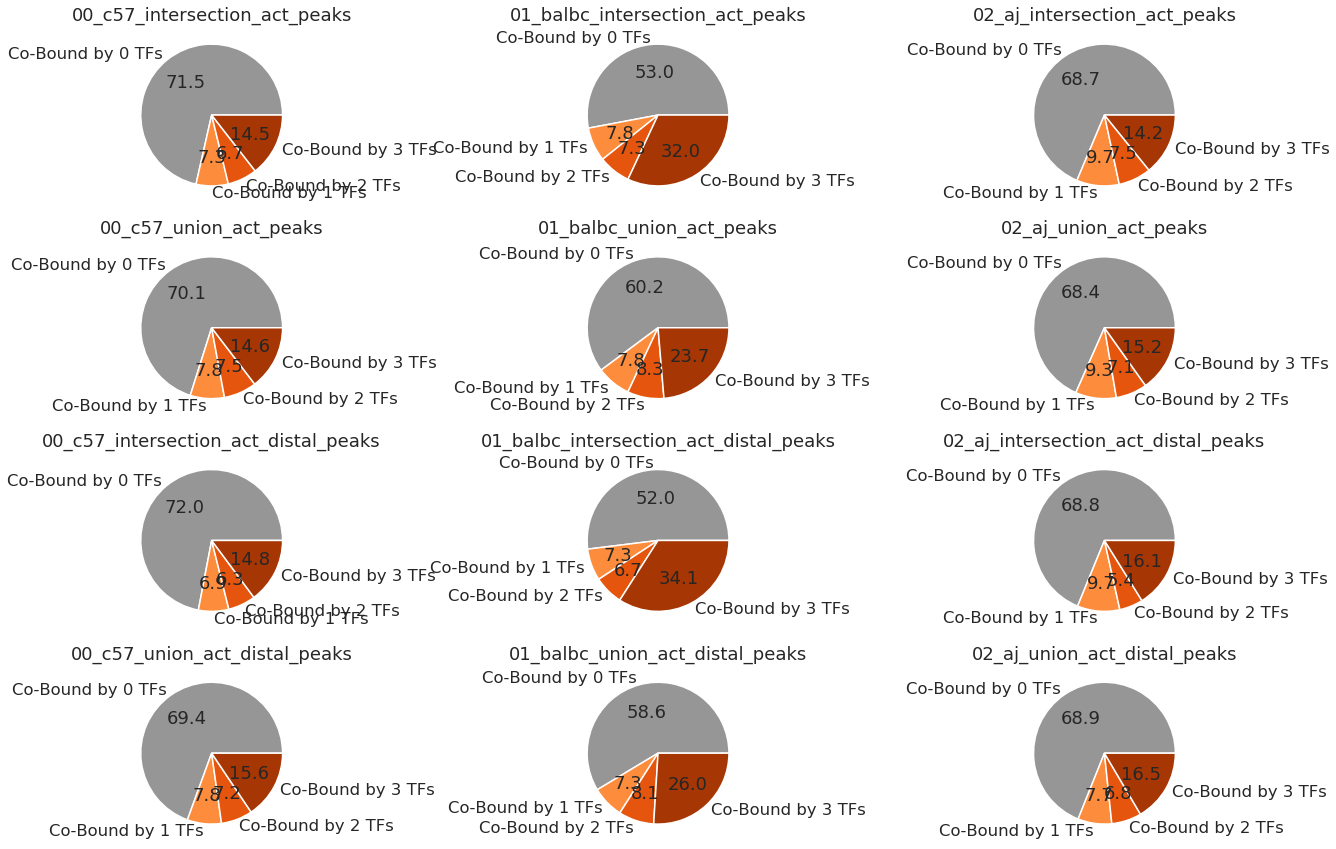

In [105]:

fig, axs = plt.subplots(4,3, figsize=(20,15))
plt.subplots_adjust(wspace=1)
for ps, ax in zip(peaksets, axs.flat):    
    n_peak_list = []
    for cb in np.sort(glob.glob('./mitf_overlap/'+ps+'*')):
        n_peak_list.append(file_len(cb) - 1)
    ax.pie(n_peak_list,
           explode=explode,
           labels=labels,
           colors=colors,
           autopct = '%.1f');
    ax.set_title(ps)
plt.savefig('./figures/mitf_family_overlap_all.png',
            bbox_inches='tight')
# plt.close()

Old ways to iterate through merge peaks

In [24]:
# with open('./mergeMitfTfePeaks_homer.sh', 'w') as f:
#     for tf in np.sort(glob.glob('../99_TFE_Family_ChIP_PeakCalling/merged_peaks/*')):
#         tfname = tf.split('/')[-1].split('_')[0]
#         for peak in np.sort(glob.glob('./motif_calling/*act*')):
#             overlap_peaks = ['mergePeaks -d given \\\n',
#                              '-matrix',
#                              peak.replace('motif_calling/',
#                                               'mitf_overlap/'+tfname+'_').replace('.txt'
#                                                                               ,'')+' \\\n',
#                              peak, tf, '>',
#                              peak.replace('motif_calling/',
#                                               'mitf_overlap/'+tfname+'_').replace('.txt',
#                                                                               '_overlap.txt'),
#                              '\n\n']
#             f.write(' '.join(overlap_peaks))

#     f.close()

In [31]:
# with open('./mergeMitfTfePeaks_homer.sh', 'w') as f:
#     for peak in np.sort(glob.glob('./motif_calling/*act*')):
#         overlap_peaks = ['mergePeaks -d given \\\n',
#                          '-matrix',
#                          peak.replace('motif_calling/',
#                                           'mitf_overlap/').replace('.txt','')+' \\\n',
#                          '-venn',
#                          peak.replace('motif_calling/',
#                                           'mitf_overlap/').replace('.txt','_venn.txt')+' \\\n',
#                          peak, ' \\\n'.join(tfs), '>',
#                          peak.replace('motif_calling/',
#                                           'mitf_overlap/').replace('.txt',
#                                                                    '_overlap.txt'),
#                          '\n\n']
#         f.write(' '.join(overlap_peaks))

#     f.close()